# Data Loading


In [402]:
#importing necessery libraries for future analysis of the dataset
import folium
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as plt
import seaborn as sns
import time
import numpy as np
import dash
from dash.dependencies import Output, Input
from dash import dcc, html, dcc
from datetime import datetime
import json
import plotly.graph_objs as go
from collections import deque
from flask import Flask, request



## Function

### Transform files

These funtions below are used to read and transform data into readable df.

How To Use:

For transforming acceleromter and gyroscope data, please use `transform_data_acceleration(file, format)`, for:
- file: Pfad to file 
- format: json or csv

Example: 
```python
ubahn1_df = transform_data_acceleration('Data/Ubahn/Json/ubahn1.json','json')
ubahn2_df = transform_data_acceleration('Data/Ubahn/Json/ubahn2.json','json')
ubahn3_df = transform_data_acceleration('Data/Ubahn/Json/ubahn3.json','json')
```
For transforming location data, please use `transform_data_location(file, format, type)`, for:
- file: Pfad to file 
- format: json or csv
- type: Type of traffic (Ubahn, Bus, Auto, etc)

Example:
`ubahn1_df_loc = transform_data_location('Data/Ubahn/Json/ubahn1.json','json', 'ubahn')`

In [383]:
#Tranform accelerometer and gyroscope data to one dataframe
def transform_data_acceleration(file, format):
    if format == 'json':
        df = pd.read_json(file)
    else:
        df = pd.read_csv(file)  
        
    acce = df[df['sensor'] == 'Accelerometer']
    acce.reset_index(drop=True, inplace=True)   
    acce = acce.drop(columns =['seconds_elapsed','sensor', 'relativeAltitude', 'pressure', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude', 'altitudeAboveMeanSeaLevel', 'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    acce['Magnitude_acce'] = np.sqrt(acce["x"] ** 2 + acce["y"] ** 2 + acce["z"] ** 2)
    
    gyro = df[df['sensor'] == 'Gyroscope']
    gyro.reset_index(drop=True, inplace=True)   
    gyro = gyro.drop(columns = ['seconds_elapsed','sensor', 'relativeAltitude', 'pressure', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude', 'altitudeAboveMeanSeaLevel', 'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    

    for df in [gyro, acce]:
         df.index = pd.to_datetime(df['time'], unit = 'ns',errors='ignore')
         df.drop(columns=['time'], inplace=True)
    #df_new = pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time')
    df_new = acce.join(gyro, lsuffix = '_acce', rsuffix = '_gyro', how = 'outer').interpolate()
   
    #df_new = pd.merge(pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time'), acce, suffixes=('', '_acce'), on='time')
    #df_new['Type'] = type
    
    return df_new

In [396]:
#Tranform location from file
def transform_data_location(file, format):
    if format == 'json':
        df = pd.read_json(file)
    else:
        df = pd.read_csv(file)   

    location = df[df['sensor'] == 'Location']
    location.reset_index(drop=True, inplace=True)
    location = location.drop(columns = ['sensor', 'z', 'y', 'x', 'relativeAltitude', 'pressure', 'version', 
                                        'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    #Speed using abs to positive
    
    location.index = pd.to_datetime(location['time'], unit = 'ns',errors='ignore')
    location.drop(columns=['time'], inplace=True)
    #location['Type'] = type
    return location

### Compute features of the data based on 5s temporal window.
These funtions below are used to find min, max, average, and standard deviation values for each 5s time period.
How To Use:

After tranforming all dataframes using transform_data_acceleration, combine the dataframes into a single dataframe, for example:

`dfs = [ubahn1_df, ubahn2_df, ubahn3_df]`


Then using `combine_into_df(dfs, type)` function, for:
- dfs as defined above 
- type as type of transport 

Example:
`df = combine_into_df(dfs, 'ubahn')`


Result returns the following columns:
- Time
- Magnitude_acce_min
- Magnitude_acce_max
- Magnitude_acce_mean
- Magnitude_acce_std
- Type

In [413]:
#Cut data into windows of 5 seconds and calculate min, max, mean and std
def create_feature_df(df, type):   
    min_values = df.resample('5s').min(numeric_only=True)
    max_values = df.resample('5s').max(numeric_only=True)
    mean_values = df.resample('5s').mean(numeric_only=True)
    std_values = df.resample('5s').std(numeric_only=True)
    #columns_to_drop = df.columns.difference(['Magnitude_acce','speed','x_acce', 'x_gyro','y_acce', 'y_gyro', 'z_acce', 'z_gyro','x','y','z'])
    columns_to_drop = df.columns.difference(['Magnitude_acce','x_acce', 'x_gyro','y_acce', 'y_gyro', 'z_acce', 'z_gyro','x','y','z'])
    for df in [min_values, max_values, mean_values, std_values]:
        df.drop(columns=columns_to_drop, inplace=True)
    feature_df = pd.merge(pd.merge(min_values, max_values, suffixes = ('_min', '_max'), on = 'time'), pd.merge(mean_values, std_values, suffixes = ('_mean', '_std'), on = 'time'), on = 'time')
    feature_df['Type'] = type

    return feature_df

In [386]:
#Combine windows data into one DataFrame (only in case there are more than one df)
def combine_into_df(dfs, type):
    combined_df = pd.concat([create_feature_df(df, type) for df in dfs])  # Apply cut_into_window to each DataFrame and concatenate them
    #combined_df.reset_index(drop=True, inplace=True)  # Reset the index of the combined DataFrame
    return combined_df

In [387]:
#Combine windows data into one DataFrame (only in case there are more than one df)
def combine_with_loc(dfs_acce, dfs_loc):
    df_new = dfs_acce.join(dfs_loc, lsuffix = '', rsuffix = '_loc', how = 'outer').interpolate()
    return df_new


### Visualization

In [398]:
def map_data(df):
    coords = [(row.latitude, row.longitude) for _, row in df.iterrows()]
    my_map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=16)
    folium.PolyLine(coords, color="blue", weight=5.0).add_to(my_map)
    return my_map

In [399]:
map_data(ubahn1_loc)

In [ ]:
MAX_DATA_POINTS = 1000
UPDATE_FREQ_MS = 100

time = deque(maxlen=MAX_DATA_POINTS)
latitude = deque(maxlen=MAX_DATA_POINTS)
longitude = deque(maxlen=MAX_DATA_POINTS)


In [412]:
from collections import deque
from datetime import datetime
import json
from flask import Flask, request
import dash
from dash import dcc
import dash_core_components as dcc
from dash import html
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import folium
import requests


MAX_DATA_POINTS = 1000
UPDATE_FREQ_MS = 100

time = deque(maxlen=MAX_DATA_POINTS)
latitude = deque(maxlen=MAX_DATA_POINTS)
longitude = deque(maxlen=MAX_DATA_POINTS)


def create_live_graph():
    app = dash.Dash(__name__, server='8000')

    app.layout = html.Div(
        [
            dcc.Graph(id="live_graph"),
            dcc.Interval(id="counter", interval=UPDATE_FREQ_MS),
        ]
    )

    @app.callback(Output("live_graph", "figure"), Input("counter", "n_intervals"))
    def update_graph(_counter):
        data = [
            go.Scatter(x=list(time), y=list(d), name=name)
            for d, name in zip([latitude, longitude], ["Latitude", "Longitude"])
        ]

        graph = {
            "data": data,
            "layout": go.Layout(
                {
                    "xaxis": {"type": "date"},
                    "yaxis": {"title": "Coordinate"},
                }
            ),
        }
        if len(time) > 0:
            graph["layout"]["xaxis"]["range"] = [min(time), max(time)]
            graph["layout"]["yaxis"]["range"] = [
                min(latitude + longitude),
                max(latitude + longitude),
            ]

        return graph

    return app

def stream_data():
    server = Flask(__name__)

    @server.route("/data", methods=["POST"])
    def data():
        if str(request.method) == "POST":
            data = json.loads(request.data)
            for d in data["payload"]:
                if d.get("name", None) == "location":
                    ts = datetime.fromtimestamp(d["time"] / 1000000000)
                    if len(time) == 0 or ts > time[-1]:
                        time.append(ts)
                        latitude.append(d["values"]["latitude"])
                        longitude.append(d["values"]["longitude"])
            
            # Send the data to the specified URL
            requests.post("http://192.168.1.99:8000/data", json=data)
            
        return "success"

    return server


def map_data(df):
    coords = [(row.latitude, row.longitude) for _, row in df.iterrows()]
    my_map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=16)
    folium.PolyLine(coords, color="blue", weight=5.0).add_to(my_map)
    return my_map


def create_map_app():
    server = Flask(__name__)
    app = dash.Dash(__name__, server=server)

    app.layout = html.Div(
        [
            html.Div(
                id="live_map",
                style={"width": "100%", "height": "500px"},
            ),
        ]
    )

    @server.route("/map", methods=["POST"])
    def map():
        if str(request.method) == "POST":
            data = json.loads(request.data)
            df = pd.DataFrame(data)
            my_map = map_data(df)
            return my_map

    return app


if __name__ == "__main__":
    stream_app = stream_data()
    live_graph_app = create_live_graph()
    map_app = create_map_app()

    stream_app.run(host="0.0.0.0", port=8000)
    live_graph_app.run_server(port=8001)
    map_app.run_server(port=8002)



ValueError: server must be a Flask app or a boolean

### Code here:

### Read data for ubahn

In [388]:
#Read date for ubahn
ubahn1_df = transform_data_acceleration('Data/Ubahn/Json/ubahn1.json','json')
ubahn2_df = transform_data_acceleration('Data/Ubahn/Json/ubahn2.json','json')
ubahn3_df = transform_data_acceleration('Data/Ubahn/Json/ubahn3.json','json')
ubahn4_df = transform_data_acceleration('Data/Ubahn/Json/ubahn4.json','json')
ubahn5_df = transform_data_acceleration('Data/Ubahn/Json/ubahn5.json','json')
ubahn6_df = transform_data_acceleration('Data/Ubahn/Json/ubahn6.json','json')
ubahn7_df = transform_data_acceleration('Data/Ubahn/Json/ubahn7.json','json')

In [397]:
ubahn1_loc = transform_data_location('Data/Ubahn/Json/ubahn1.json','json')
ubahn2_loc = transform_data_location('Data/Ubahn/Json/ubahn2.json','json')
ubahn3_loc = transform_data_location('Data/Ubahn/Json/ubahn3.json','json')
ubahn4_loc = transform_data_location('Data/Ubahn/Json/ubahn4.json','json')
ubahn5_loc = transform_data_location('Data/Ubahn/Json/ubahn5.json','json')
ubahn6_loc = transform_data_location('Data/Ubahn/Json/ubahn6.json','json')
ubahn7_loc = transform_data_location('Data/Ubahn/Json/ubahn7.json','json')

In [379]:
dfs = [ubahn1_df, ubahn2_df, ubahn3_df, ubahn4_df, ubahn5_df, ubahn6_df, ubahn7_df]
ubahn_df = combine_into_df(dfs, 'ubahn')
ubahn_df.head()

,z_acce_min,y_acce_min,x_acce_min,Magnitude_acce_min,z_gyro_min,y_gyro_min,x_gyro_min,z_acce_max,y_acce_max,x_acce_max,...,y_gyro_mean,x_gyro_mean,z_acce_std,y_acce_std,x_acce_std,Magnitude_acce_std,z_gyro_std,y_gyro_std,x_gyro_std,Type
time,,,,,,,,,,,,,,,,,,,,,
2023-05-24 06:22:00,-6.192753,-4.467911,-5.961443,0.006873,-4.469584,-3.980495,-2.605372,4.875706,4.418312,4.369516,...,0.004650,-0.001426,0.533630,0.406217,0.532307,0.674416,0.242763,0.272466,0.243138,ubahn
2023-05-24 06:23:00,-3.126415,-1.559673,-2.170109,0.006435,-0.153267,-1.067077,-0.603562,2.815332,0.983169,2.875069,...,-0.010453,0.002009,0.338297,0.224130,0.232430,0.327992,0.040574,0.041049,0.068509,ubahn
2023-05-24 06:24:00,-2.298995,-2.410858,-1.670463,0.006225,-0.556380,-1.151870,-1.420616,3.270291,1.561461,2.005978,...,0.000996,-0.000619,0.314884,0.215477,0.179626,0.318229,0.061830,0.120089,0.145741,ubahn
2023-05-24 06:25:00,-5.703038,-4.931885,-3.319084,0.006647,-1.319973,-3.656870,-2.834619,7.878510,4.091962,7.460892,...,-0.000344,-0.001707,0.580002,0.394580,0.368340,0.650728,0.144341,0.311813,0.287094,ubahn
2023-05-24 06:26:00,-17.710230,-13.335277,-10.617250,0.012087,-3.566892,-4.851945,-4.105123,8.715245,11.828955,9.331444,...,0.003517,-0.005304,1.251087,0.947034,1.135419,1.661129,0.448374,0.638422,0.504145,ubahn


In [381]:
ubahn_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46 entries, 2023-05-24 06:22:00 to 2023-05-23 11:08:00
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   z_acce_min           46 non-null     float64
 1   y_acce_min           46 non-null     float64
 2   x_acce_min           46 non-null     float64
 3   Magnitude_acce_min   46 non-null     float64
 4   z_gyro_min           46 non-null     float64
 5   y_gyro_min           46 non-null     float64
 6   x_gyro_min           46 non-null     float64
 7   z_acce_max           46 non-null     float64
 8   y_acce_max           46 non-null     float64
 9   x_acce_max           46 non-null     float64
 10  Magnitude_acce_max   46 non-null     float64
 11  z_gyro_max           46 non-null     float64
 12  y_gyro_max           46 non-null     float64
 13  x_gyro_max           46 non-null     float64
 14  z_acce_mean          46 non-null     float64
 15  y_ac

In [310]:
ubahn_df.isnull().sum() 

(x,y,z)

Magnitude_acce_min     0
Magnitude_acce_max     0
Magnitude_acce_mean    0
Magnitude_acce_std     0
Type                   0
dtype: int64

### Read data for fahrrad

In [311]:
#Read data for fahrrad
fahrrad2_df = transform_data_acceleration('Data/Fahrrad/Fahrrad2.json','json')
fahrrad3_df = transform_data_acceleration('Data/Fahrrad/Fahrrad3.json','json')
fahrrad2_df.head()

,z_acce,y_acce,x_acce,Magnitude_acce,z_gyro,y_gyro,x_gyro
time,,,,,,,
2023-05-24 10:57:22.707848960,-0.145448,0.027461,0.008292,0.148250,-0.022874,-0.059316,0.021992
2023-05-24 10:57:22.717913856,-0.126788,0.007323,0.009061,0.127322,-0.015238,-0.061070,0.017357
2023-05-24 10:57:22.727979008,0.008563,-0.037565,-0.029014,0.048231,-0.007340,-0.054365,-0.009055
2023-05-24 10:57:22.738043904,0.168166,-0.065213,-0.043134,0.185454,-0.001951,-0.048770,-0.041461
2023-05-24 10:57:22.748108800,0.212968,-0.053833,0.012392,0.220016,0.007909,-0.064258,-0.060135


In [317]:
dfs = [fahrrad2_df, fahrrad3_df]
fahrrad_df = combine_into_df(dfs, 'fahrrad')
fahrrad_df.head()

,Magnitude_acce_min,Magnitude_acce_max,Magnitude_acce_mean,Magnitude_acce_std,Type
time,,,,,
2023-05-24 10:57:00,0.014630,47.460605,1.923795,2.290016,fahrrad
2023-05-24 10:58:00,0.066637,13.530950,1.982461,1.053979,fahrrad
2023-05-24 10:59:00,0.064018,19.996949,1.989542,1.461019,fahrrad
2023-05-24 11:00:00,0.109977,18.138574,2.464768,1.515412,fahrrad
2023-05-24 11:01:00,0.049495,14.497144,2.070326,1.228905,fahrrad


### Read data for auto

In [318]:
def transform_data_acce_special(file, format):
    if format == 'json':
        acce = pd.read_json(file)
    elif format == 'csv':
        acce = pd.read_csv(file)
    acce.reset_index(drop=True, inplace=True)   
    #acce = acce.drop(columns =['sensor', 'relativeAltitude', 'pressure', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude', 'altitudeAboveMeanSeaLevel', 'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    acce['Magnitude_acce'] = np.sqrt(acce["x"] ** 2 + acce["y"] ** 2 + acce["z"] ** 2)
    acce.index = pd.to_datetime(acce['time'], unit = 'ns',errors='ignore')
    acce.drop(columns=['time','seconds_elapsed'], inplace=True)
    return acce


In [319]:
auto_1 = transform_data_acce_special('Data/Auto/Accelerometer1.csv','csv')
auto_2 = transform_data_acce_special('Data/Auto/Accelerometer2.csv', 'csv')
auto_3 = transform_data_acce_special('Data/Auto/Accelerometer3.csv', 'csv')
auto_4 = transform_data_acce_special('Data/Auto/Accelerometer4.csv', 'csv')
auto_5 = transform_data_acce_special('Data/Auto/Accelerometer stadt.csv','csv')

In [320]:
auto_1.head()

,z,y,x,Magnitude_acce
time,,,,
2023-06-25 11:47:05.322180900,-0.070814,0.436153,0.773279,0.890620
2023-06-25 11:47:05.332144000,0.407211,0.208168,0.629366,0.777982
2023-06-25 11:47:05.342108000,0.584028,-0.064646,0.434051,0.730526
2023-06-25 11:47:05.352072000,0.596304,-0.137638,0.376241,0.718386
2023-06-25 11:47:05.362034700,0.548339,-0.068933,0.372291,0.666354


In [321]:
dfs = [auto_1, auto_2, auto_3, auto_4, auto_5]
auto_df = combine_into_df(dfs, 'auto')
auto_df.head()

,Magnitude_acce_min,Magnitude_acce_max,Magnitude_acce_mean,Magnitude_acce_std,Type
time,,,,,
2023-06-25 11:47:00,0.053698,7.895018,1.050124,0.753284,auto
2023-06-25 11:48:00,0.012282,5.761362,0.806279,0.556126,auto
2023-06-25 11:49:00,0.087672,1.721433,0.625852,0.282354,auto
2023-06-25 11:38:00,0.044099,7.324106,0.907511,0.752026,auto
2023-06-25 11:39:00,0.018567,6.737385,0.928878,0.619338,auto


In [322]:
auto_df.isnull().sum()

Magnitude_acce_min     0
Magnitude_acce_max     0
Magnitude_acce_mean    0
Magnitude_acce_std     0
Type                   0
dtype: int64

### Read data for bus

In [323]:
#Tranform accelerometer and gyroscope data to one dataframe
def transform_data_acceleration_bus(file, format):
    if format == 'json':
        df = pd.read_json(file)
    else:
        df = pd.read_csv(file)  
        
    acce = df[df['sensor'] == 'Accelerometer']
    acce.reset_index(drop=True, inplace=True)   
    acce = acce.drop(columns =['seconds_elapsed','sensor', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude',  'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    acce['Magnitude_acce'] = np.sqrt(acce["x"] ** 2 + acce["y"] ** 2 + acce["z"] ** 2)
    
    gyro = df[df['sensor'] == 'Gyroscope']
    gyro.reset_index(drop=True, inplace=True)   
    gyro = gyro.drop(columns = ['seconds_elapsed','sensor', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude',  'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    

    for df in [gyro, acce]:
         df.index = pd.to_datetime(df['time'], unit = 'ns',errors='ignore')
         df.drop(columns=['time'], inplace=True)
    #df_new = pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time')
    df_new = acce.join(gyro, lsuffix = '_acce', rsuffix = '_gyro', how = 'outer').interpolate()
   
    #df_new = pd.merge(pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time'), acce, suffixes=('', '_acce'), on='time')
    #df_new['Type'] = type
    
    return df_new

In [325]:
bus1 = transform_data_acceleration_bus('Data/Bus/Bus_Bauvereinstr.-Technische Hochschule-Dürrenhof.23-05-23_18-29-17.json', 'json')
bus2 = transform_data_acceleration_bus('Data/Bus/Bus_Harmoniestr.-Wöhrd.23-05-23_18-27-14.json','json')
bus3 = transform_data_acceleration_bus('Data/Bus/Bus_Laufer Tor-Rathenauplatz.23-05-23_18-24-45.json','json')
bus4 = transform_data_acceleration_bus('Data/Bus/Bus_Rathenauplatz-Harmoniestr.23-05-23_18-25-46.json','json')
bus5 = transform_data_acceleration_bus('Data/Bus/Bus_Wöhrd-Bauvereinstr.23-05-23_18-28-17.json','json')
bus6 = transform_data_acceleration_bus('Data/Bus/bus-_Gleitwitzertr._-_Langwasser_Mitte-2023-05-24_12-06-59 2.json','json')
bus7 = transform_data_acceleration_bus('Data/Bus/Bus2_Dürrenhof-Stephanstr.23-05-23_18-31-17.json','json')


In [327]:
dfs = [bus1, bus2, bus3, bus4, bus5, bus6, bus7]
bus_df = combine_into_df(dfs, 'bus')
bus_df.head()

,Magnitude_acce_min,Magnitude_acce_max,Magnitude_acce_mean,Magnitude_acce_std,Type
time,,,,,
2023-05-23 16:29:00,0.029526,4.765777,0.778741,0.489801,bus
2023-05-23 16:30:00,0.007792,6.163621,0.711895,0.520581,bus
2023-05-23 16:31:00,0.056838,2.848695,0.786793,0.452671,bus
2023-05-23 16:27:00,0.054349,5.938608,0.951735,0.645907,bus
2023-05-23 16:28:00,0.076887,5.414399,0.880589,0.650603,bus


In [328]:
bus_df.isnull().sum()

Magnitude_acce_min     0
Magnitude_acce_max     0
Magnitude_acce_mean    0
Magnitude_acce_std     0
Type                   0
dtype: int64

### Comlete pipeline

In [329]:
df_completed = pd.concat([ubahn_df, fahrrad_df, auto_df, bus_df])

In [330]:
df_completed.isnull().sum()

Magnitude_acce_min     0
Magnitude_acce_max     0
Magnitude_acce_mean    0
Magnitude_acce_std     0
Type                   0
dtype: int64

In [331]:
df_completed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126 entries, 2023-05-24 06:22:00 to 2023-05-23 16:32:00
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Magnitude_acce_min   126 non-null    float64
 1   Magnitude_acce_max   126 non-null    float64
 2   Magnitude_acce_mean  126 non-null    float64
 3   Magnitude_acce_std   126 non-null    float64
 4   Type                 126 non-null    object 
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


## Training the model

### Decision Tree Classification

In [332]:
#importing decision tree model
from sklearn.metrics import mean_squared_error
import numpy as np 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [333]:
#separating labels and predictors
X = df_completed.drop('Type',axis=1)
y = df_completed['Type'].values

#splitting train (75%) and test set (25%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

In [334]:
#Gini index as our attribute selection method for the training of decision tree classifier with Sklearn function DecisionTreeClassifier()
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5)   
clf_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)

In [335]:
#Define target and features using
target = list(df_completed['Type'].unique())
feature_names = list(X.columns)
print(target)
print(feature_names)

['ubahn', 'fahrrad', 'auto', 'bus']
['Magnitude_acce_min', 'Magnitude_acce_max', 'Magnitude_acce_mean', 'Magnitude_acce_std']


In [336]:
#Train model using Decision Tree Classifier
classifier_decision_tree = tree.DecisionTreeClassifier()
classifier_decision_tree.fit(X_train, y_train)
tree_predictions = classifier_decision_tree.predict(X_train)
y_predict = clf_model.predict(X_test)

In [337]:
#Calculate accuracy
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
acc = accuracy_score(y_test,y_predict)
print("Accuracy of Decision Tree Classifier: " + str(acc))
#print(classification_report(y_test, y_predict))

Accuracy of Decision Tree Classifier: 0.631578947368421


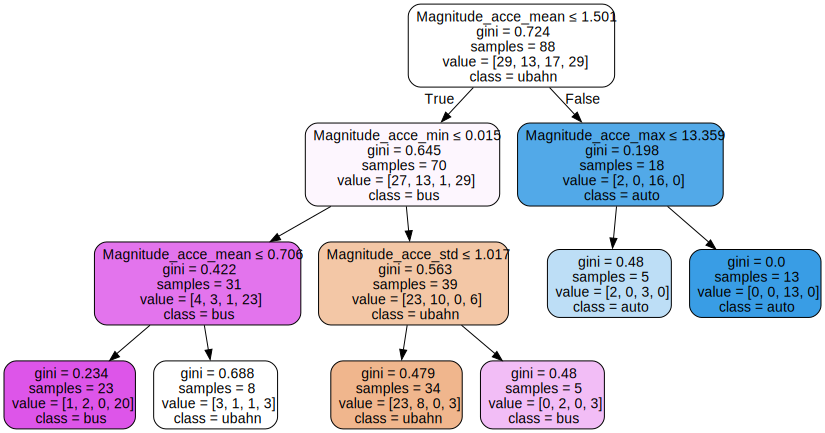

In [338]:
import graphviz
dot_data = tree.export_graphviz(clf_model,
                                out_file=None, 
                      feature_names=feature_names,  
                      class_names=target,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  

graph

In [339]:
import pickle 

knnPickle = open('knnpickle_file', 'wb')
rfPickle = open('rfpickle_file', 'wb')
featuresList = open('featuresList_file', 'wb')

pickle.dump(knn,knnPickle)
pickle.dump(rf, rfPickle)
pickle.dump(df_tolist,featuresList)

knnPickle.close()
rfPickle.close()
featuresList.close()

NameError: name 'knn' is not defined

### Random Forest Classification

In [ ]:
#randomforest
from sklearn.ensemble import RandomForestClassifier
rf_model= RandomForestClassifier()
rf_model.fit(X_train,y_train)
rf_predictions = rf_model.predict(X_test)
y_pred = clf_model.predict(X_test)

In [ ]:
#Calculate accuracy
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
acccuracy = accuracy_score(y_test,y_pred)
print("Accuracy of Random Forest Classifier: " + str(acccuracy))
#print(classification_report(y_test, y_predict))

Accuracy of Random Forest Classifier: 0.631578947368421


In [ ]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

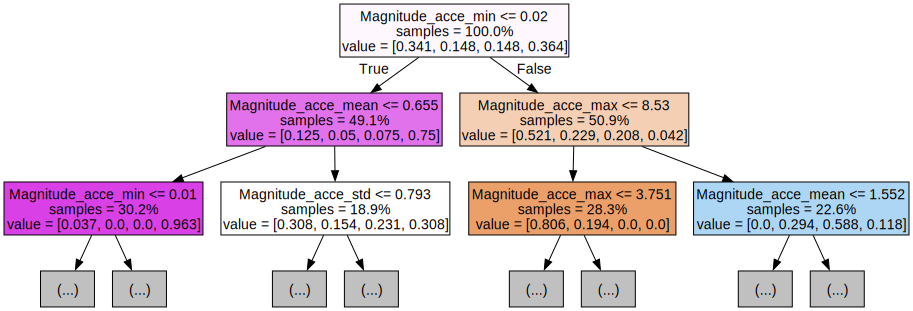

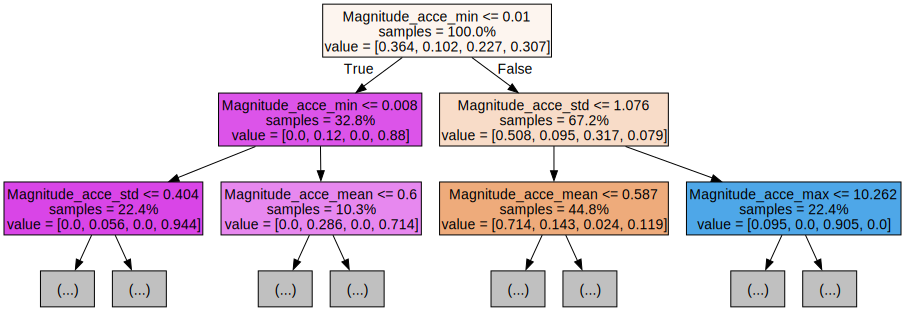

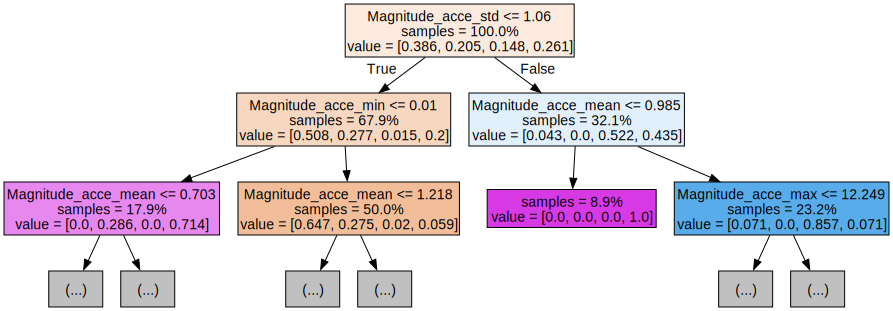

In [ ]:
for i in range(3):
    tree = rf_model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph )